In [1]:
import sys,os
sys.path.append("..")
import django
django.setup()
from crawlers.models import *
import pandas as pd
from django.db.models import Q
import datetime
from crawlers.finlab.import_tools import *

In [2]:
class GetModelDateRangeBySlice:
    def __init__(self, model, offset=0, limit=100000, recent=True):
        self.model = model
        self.offset = offset
        self.limit = limit
        self.recent = recent

    def get_date_list(self, conn):
        table = self.model._meta.db_table
        if self.recent:
            cursor = sorted(list(conn.execute("SELECT DISTINCT date FROM " + table)))[-self.offset:self.limit]
        else:
            cursor = sorted(list(conn.execute("SELECT DISTINCT date FROM " + table)))[
                     self.offset:self.offset + self.limit]
        cursor = [cursor[i][0] for i in range(len(cursor))]
        return cursor

    
# GetModelDateRangeBySlice(StockTdccTW,24).get_date_list(engine)

In [4]:
class OrmBasicFilter(GetModelDateRangeBySlice):
    def __init__(self, model, stock_id, start_date=None, end_date=None, offset=0, limit=100000, recent=True,
                 fields=None):
        super().__init__(model, offset, limit, recent)
        self.stock_id = stock_id
        self.start_date = start_date
        self.end_date = end_date
        self.fields = fields

    def basic_filter_set(self):
        query = {}
        if self.stock_id is not None:
            query['stock_id'] = self.stock_id
        if self.start_date is not None:
            query['date__gte'] = self.start_date
        if self.end_date is not None:
            query['date__lte'] = self.end_date
        if (self.offset is not 0) and (self.limit is not 100000):
            date_range = self.get_date_list(engine)
            query['date__gte'] = date_range[0]
            query['date__lte'] = date_range[-1]
        return query

    def get_orm_data(self):
        fs = self.basic_filter_set()
        if self.fields is not None:
            fields = self.fields.split('-')
            orm_data = self.model.objects.filter(**fs).order_by('date').values(*fields)
        else:
            orm_data = self.model.objects.filter(**fs).order_by('date').values()
        return orm_data

    def get_dataframe(self):
        df = pd.DataFrame(self.get_orm_data())
        return df

class ReloadTdccTW(OrmBasicFilter):
    group_list = ['little', 'medium', 'big', 'super', 'total']

    def dataframe_process(self):
        group_list = self.group_list
        df = self.get_dataframe()
        df['hold_class_group'] = [
            group_list[0] if i < 10 else group_list[1] if i < 12 else group_list[2] if i < 15 else group_list[
                3] if i < 16 else group_list[4] for i in df['hold_class']]
        df = df.groupby(['stock_id', 'date', 'hold_class_group'])[['people', 'hold_num', 'hold_pt']].sum()
        df['hold_num'] = round(df['hold_num'] / 1000)
        df['hold_pt'] = round(df['hold_pt'], 2)
        df = df.reset_index()
        return df

    def group_data(self):
        context = {}
        df = self.dataframe_process()
        context["stock_id"] = self.stock_id
        context["date"] = sorted(list(set(df['date'].values)))
        df = df.drop(columns=['stock_id', 'date'])
        for group in self.group_list:
            context[group] = list(
                df[df['hold_class_group'] == group].drop(columns='hold_class_group').T.to_dict().values())
        context['price'] = list(StockPriceTW.objects.filter(stock_id=self.stock_id, date__in=context["date"]).values())
        return context
    
df=ReloadTdccTW(StockTdccTW,'2330',offset=52).group_data()
df

{'stock_id': '2330',
 'date': [datetime.date(2019, 5, 31),
  datetime.date(2019, 6, 6),
  datetime.date(2019, 6, 14),
  datetime.date(2019, 6, 21),
  datetime.date(2019, 6, 28),
  datetime.date(2019, 7, 5),
  datetime.date(2019, 7, 12),
  datetime.date(2019, 7, 19),
  datetime.date(2019, 7, 26),
  datetime.date(2019, 8, 2),
  datetime.date(2019, 8, 8),
  datetime.date(2019, 8, 16),
  datetime.date(2019, 8, 23),
  datetime.date(2019, 8, 30),
  datetime.date(2019, 9, 6),
  datetime.date(2019, 9, 12),
  datetime.date(2019, 9, 20),
  datetime.date(2019, 9, 27),
  datetime.date(2019, 10, 4),
  datetime.date(2019, 10, 9),
  datetime.date(2019, 10, 18),
  datetime.date(2019, 10, 25),
  datetime.date(2019, 11, 1),
  datetime.date(2019, 11, 8),
  datetime.date(2019, 11, 15),
  datetime.date(2019, 11, 22),
  datetime.date(2019, 11, 29),
  datetime.date(2019, 12, 6),
  datetime.date(2019, 12, 13),
  datetime.date(2019, 12, 20),
  datetime.date(2019, 12, 27),
  datetime.date(2020, 1, 3),
  datetim

In [16]:
df=ReloadTdccTW(StockTdccTW,'6263',offset=52).group_data()
df

{'stock_id': '6263',
 'date': [datetime.date(2019, 6, 6),
  datetime.date(2019, 6, 14),
  datetime.date(2019, 6, 21),
  datetime.date(2019, 6, 28),
  datetime.date(2019, 7, 5),
  datetime.date(2019, 7, 12),
  datetime.date(2019, 7, 19),
  datetime.date(2019, 7, 26),
  datetime.date(2019, 8, 2),
  datetime.date(2019, 8, 8),
  datetime.date(2019, 8, 16),
  datetime.date(2019, 8, 23),
  datetime.date(2019, 8, 30),
  datetime.date(2019, 9, 6),
  datetime.date(2019, 9, 12),
  datetime.date(2019, 9, 20),
  datetime.date(2019, 9, 27),
  datetime.date(2019, 10, 4),
  datetime.date(2019, 10, 9),
  datetime.date(2019, 10, 18),
  datetime.date(2019, 10, 25),
  datetime.date(2019, 11, 1),
  datetime.date(2019, 11, 8),
  datetime.date(2019, 11, 15),
  datetime.date(2019, 11, 22),
  datetime.date(2019, 11, 29),
  datetime.date(2019, 12, 6),
  datetime.date(2019, 12, 13),
  datetime.date(2019, 12, 20),
  datetime.date(2019, 12, 27),
  datetime.date(2020, 1, 3),
  datetime.date(2020, 1, 10),
  datetim

# Seaborn Test

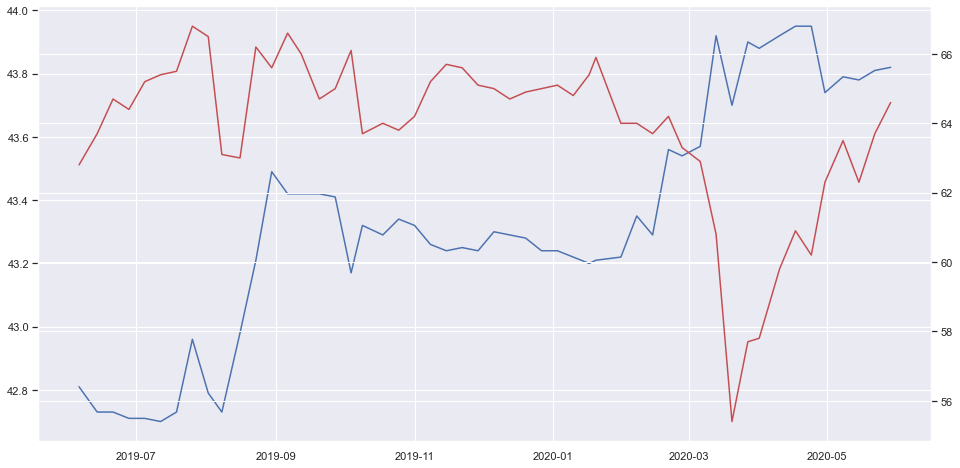

In [19]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
fmri = sns.load_dataset("fmri")
ax = sns.lineplot(x=df['date'], y=[i['hold_pt'] for i in df['little']])
ax2 = ax.twinx()
ax2 = sns.lineplot(x=df['date'], y=[i['close_price'] for i in df['price']], color="r")
plt.show()


In [17]:
y=[i['hold_pt'] for i in df['little']]
len(y)

52

In [18]:
y=[i['hold_pt'] for i in df['little']]
len(y)

52